# Background

In [40]:
#!pip install yfinance

In [41]:
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
import datetime
import requests
import numpy as np
import pandas as pd
import yfinance as yf

# Type in Date and Trade Name

In [42]:
#History Data Time Frame
Startdate = "2004-5-01"
Enddate = "2024-05-04"

Startdate = pd.to_datetime(Startdate)
Enddate = pd.to_datetime(Enddate)

Beta_year = 5
B = Beta_year*12
B = int(B)
print(B)

Trade_Name = "XOM"

Stock = yf.download(Trade_Name, interval='1mo')
Stock.insert(0, "Index", range(1, 1 + len(Stock)))
Stock = Stock.reset_index(drop=False)

60


[*********************100%%**********************]  1 of 1 completed


In [43]:
print(Stock.Date[0].strftime("%Y-%m"))
print(Stock.Date.iloc[-1].strftime("%Y-%m"))

1985-01
2024-05


In [44]:
try:
    assert Stock.Date[0] < Startdate
except AssertionError:
    raise ValueError(f"Choose start date later than {Stock.Date[0].strftime('%Y-%m')}")

In [45]:
from dateutil.relativedelta import relativedelta
# Calculate the difference in months
difference = relativedelta(Startdate, Stock.Date.iloc[0])
total_months = difference.years * 12 + difference.months

try:
    assert total_months > B
except AssertionError:
    raise ValueError(f"Change Beta to be less than {round(total_months/12, 2)} or change start date")

# Basic Data

In [46]:
Startdate = pd.to_datetime(Startdate) - relativedelta(years=Beta_year)
Enddate = pd.to_datetime(Enddate)

In [47]:
#Risk-Free rate taken as Treasury bond from Yahoo Finance: 13 Week Treasury Bill: ^IRX, 	Treasury Yield 5 Years: ^FVX, Treasury Yield 10 Years: ^TNX, Treasury Yield 30 Years: ^TYX
TB13W = yf.download("^IRX",start=Startdate,end=Enddate, interval='1mo')
TB5 = yf.download("^FVX",start=Startdate,end=Enddate, interval='1mo')
TB10 = yf.download("^TNX",start=Startdate,end=Enddate, interval='1mo')
TB30 = yf.download("^TYX",start=Startdate,end=Enddate, interval='1mo')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [48]:
Risk_Free = TB5
Risk_Free = Risk_Free.reset_index(drop=False)

Risk_Free.tail(3)

,Date,Open,High,Low,Close,Adj Close,Volume
298,2024-03-01,4.257,4.368,3.994,4.220,4.220,0
299,2024-04-01,4.232,4.753,4.232,4.723,4.723,0
300,2024-05-01,4.698,4.723,4.563,4.567,4.567,0


In [49]:
Risk_Free.iloc[:, 1:].describe()

,Open,High,Low,Close,Adj Close,Volume
count,301.000000,301.000000,301.000000,301.000000,301.000000,3.010000e+02
mean,2.765322,2.969468,2.565674,2.757492,2.757492,2.251694e+04
std,1.564052,1.584530,1.536736,1.562334,1.562334,2.030175e+05
min,0.219000,0.304000,0.192000,0.215000,0.215000,0.000000e+00
25%,1.507000,1.724000,1.325000,1.511000,1.511000,0.000000e+00
50%,2.544000,2.760000,2.348000,2.524000,2.524000,0.000000e+00
75%,4.032000,4.301000,3.778000,4.055000,4.055000,0.000000e+00
max,6.653000,6.830000,6.517000,6.692000,6.692000,2.801100e+06


In [50]:
SP_500 = yf.download("^GSPC",start=Startdate,end=Enddate, interval='1mo')
#SP_500 = yf.download("SPY",start=Startdate,end=Enddate, interval='1mo')
NASDAQ = yf.download("^IXIC",start=Startdate,end=Enddate, interval='1mo')
VTI = yf.download("VTI",start=Startdate,end=Enddate, interval='1mo')
Dow_Jones = yf.download("^DJI",start=Startdate,end=Enddate, interval='1mo')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [51]:
#Market Return based on S&P500 Index data from Yahoo Finance
Market = SP_500
Market = Market.reset_index(drop=False)

Market.tail(3)

,Date,Open,High,Low,Close,Adj Close,Volume
298,2024-03-01,5098.509766,5264.850098,5056.819824,5254.350098,5254.350098,86299510000
299,2024-04-01,5257.970215,5263.950195,4953.560059,5035.689941,5035.689941,81747170000
300,2024-05-01,5029.029785,5096.120117,5011.049805,5064.200195,5064.200195,8925830000


In [52]:
Market.iloc[:, 1:].describe()

,Open,High,Low,Close,Adj Close,Volume
count,301.000000,301.000000,301.000000,301.000000,301.000000,3.010000e+02
mean,2000.860194,2068.161996,1930.229700,2011.860430,2011.860430,6.831949e+10
std,1109.630339,1148.190353,1074.939415,1121.013330,1121.013330,3.019776e+10
min,729.570007,832.979980,666.789978,735.090027,735.090027,8.925830e+09
25%,1207.010010,1239.780029,1165.540039,1207.010010,1207.010010,4.203009e+10
50%,1440.900024,1498.020020,1403.280029,1452.430054,1452.430054,7.341696e+10
75%,2633.449951,2717.489990,2520.399902,2647.580078,2647.580078,8.597863e+10
max,5257.970215,5264.850098,5056.819824,5254.350098,5254.350098,1.621854e+11


In [53]:
Stock = yf.download(Trade_Name,start = Startdate, end = Enddate, interval='1mo')
Stock = Stock.reset_index(drop=False)

[*********************100%%**********************]  1 of 1 completed


In [54]:
Stock.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1999-05-01,41.5000,43.62500,38.78125,39.9375,18.398451,180442400
1,1999-06-01,39.8125,41.71875,37.43750,38.5625,17.853277,156534200
2,1999-07-01,38.5625,40.81250,37.65625,39.6875,18.374121,149662400


In [55]:
Stock.iloc[:,1:].describe()

,Open,High,Low,Close,Adj Close,Volume
count,301.000000,301.000000,301.000000,301.000000,301.000000,3.010000e+02
mean,70.041312,73.383289,66.773908,70.222122,47.534962,3.697822e+08
std,21.870133,22.459462,21.122710,22.005982,22.939290,1.786000e+08
min,32.180000,35.090000,29.750000,31.900000,15.874784,5.329130e+07
25%,46.290001,51.970001,44.290001,48.330002,30.619877,2.394018e+08
50%,74.269997,77.760002,70.269997,74.360001,48.368671,3.158961e+08
75%,86.599998,89.370003,82.989998,86.500000,58.342930,4.462582e+08
max,118.279999,123.750000,115.660004,118.339996,118.269997,1.384259e+09


# Return Rate

In [56]:
#Calcuate risk free return for each month
Risk_Free = Risk_Free.rename(columns = {"Adj Close":"TB"})
Risk_Free["Date"] = pd.to_datetime(Risk_Free["Date"])
Risk_Free["TB"] = pd.to_numeric(Risk_Free["TB"])
#Risk_Free["Risk-Free Return"] = Risk_Free["TB"]/100
#Risk_Free["Risk-Free Return"] = ((1+Risk_Free["Risk-Free Return"])**(1/12))-1

#Risk_Free["Risk-Free Return"] = Risk_Free["TB"].apply(lambda x: ((1 + x / 100) ** (1/12)) - 1)
Risk_Free["Risk-Free Return"] = Risk_Free["TB"].apply(lambda x: (x/12)/100)


Risk_Free = Risk_Free.dropna()

"""
first_value = Risk_Free["Risk-Free Return"].iloc[0]
Risk_Free["Risk-Free Return"] = first_value
"""

Risk_Free = Risk_Free[["Date", "TB", "Risk-Free Return"]]

Risk_Free.tail(10)

,Date,TB,Risk-Free Return
291,2023-08-01,4.244,0.003537
292,2023-09-01,4.606,0.003838
293,2023-10-01,4.816,0.004013
294,2023-11-01,4.298,0.003582
295,2023-12-01,3.840,0.003200
296,2024-01-01,3.882,0.003235
297,2024-02-01,4.262,0.003552
298,2024-03-01,4.220,0.003517
299,2024-04-01,4.723,0.003936
300,2024-05-01,4.567,0.003806


In [57]:
#Creat a function to calucalte stock/market return caompare value with previuos one

def Return_Rate(x, y, z):
    x = x.rename(columns={"Adj Close": y})
    x["Date"] = pd.to_datetime(x["Date"])
    x[y] = pd.to_numeric(x[y])
    x[y + "_Prev"] = x[y].shift(periods=1)
    x[z] = x[y].pct_change()
    x = x.dropna()

    return x

In [58]:
Stock = Return_Rate(Stock, "Stock Value", "Stock Return")

Market = Return_Rate(Market, "Market Value", "Market Return")

In [59]:
Stock.tail(10)

,Date,Open,High,Low,Close,Stock Value,Volume,Stock Value_Prev,Stock Return
291,2023-08-01,106.949997,112.070000,104.570000,111.190002,108.280273,315896100,104.433624,0.036833
292,2023-09-01,112.199997,120.699997,112.199997,117.580002,115.441681,320550000,108.280273,0.066138
293,2023-10-01,117.529999,117.790001,104.540001,105.849998,103.925003,493930700,115.441681,-0.099762
294,2023-11-01,106.529999,109.190002,101.150002,102.739998,100.871552,433367400,103.925003,-0.029381
295,2023-12-01,102.500000,104.220001,97.480003,99.980003,99.059380,453909500,100.871552,-0.017965
296,2024-01-01,100.919998,104.879997,95.769997,102.809998,101.863312,413171900,99.059380,0.028306
297,2024-02-01,103.570000,105.430000,100.419998,104.519997,103.557571,360899900,101.863312,0.016633
298,2024-03-01,105.720001,116.449997,104.029999,116.239998,116.239998,353938800,103.557571,0.122467
299,2024-04-01,116.410004,123.750000,115.379997,118.269997,118.269997,385710200,116.239998,0.017464
300,2024-05-01,118.279999,118.470001,115.660004,116.239998,116.239998,53291300,118.269997,-0.017164


In [60]:
Market.tail(10)

,Date,Open,High,Low,Close,Market Value,Volume,Market Value_Prev,Market Return
291,2023-08-01,4578.830078,4584.620117,4335.310059,4507.660156,4507.660156,86840820000,4588.959961,-0.017716
292,2023-09-01,4530.600098,4541.250000,4238.629883,4288.049805,4288.049805,73482980000,4507.660156,-0.048719
293,2023-10-01,4284.520020,4393.569824,4103.779785,4193.799805,4193.799805,83519460000,4288.049805,-0.021980
294,2023-11-01,4201.270020,4587.640137,4197.740234,4567.799805,4567.799805,80970570000,4193.799805,0.089179
295,2023-12-01,4559.430176,4793.299805,4546.500000,4769.830078,4769.830078,81530670000,4567.799805,0.044229
296,2024-01-01,4745.200195,4931.089844,4682.109863,4845.649902,4845.649902,81737880000,4769.830078,0.015896
297,2024-02-01,4861.109863,5111.060059,4853.520020,5096.270020,5096.270020,82066930000,4845.649902,0.051721
298,2024-03-01,5098.509766,5264.850098,5056.819824,5254.350098,5254.350098,86299510000,5096.270020,0.031019
299,2024-04-01,5257.970215,5263.950195,4953.560059,5035.689941,5035.689941,81747170000,5254.350098,-0.041615
300,2024-05-01,5029.029785,5096.120117,5011.049805,5064.200195,5064.200195,8925830000,5035.689941,0.005662


In [61]:
Market['Market Return'].tail(60).mean()*12

0.13884222750383207

# Premium

In [62]:
# Create a function to calculate the market/stock premium
# by taking the market/stock return and subtracting the risk free return
# Manipulating the data to fit our format by renaming columns
def Premium(x, y, z, a, b):
  x = pd.merge(y, Risk_Free, on = "Date")
  x[z] = x[a] - x["Risk-Free Return"]
  x = x[["Date", "Risk-Free Return", z, b]]
  x = x.rename(columns = {"Date_y":"Date"})
  return x

In [63]:
#Run function to get Market/Stock Premium
Market_Premium = Premium('Market_Premium', Market, 'Market Premium', 'Market Return', 'Market Return')

Stock_Premium = Premium('Stock_Premium', Stock, 'Stock Premium', 'Stock Return', 'Stock Return')

In [64]:
Market_Premium.tail(5)

,Date,Risk-Free Return,Market Premium,Market Return
295,2024-01-01,0.003235,0.012661,0.015896
296,2024-02-01,0.003552,0.048169,0.051721
297,2024-03-01,0.003517,0.027502,0.031019
298,2024-04-01,0.003936,-0.045551,-0.041615
299,2024-05-01,0.003806,0.001856,0.005662


In [65]:
Market_Premium.tail(12).mean()

Date                2023-11-15 20:00:00
Risk-Free Return               0.003595
Market Premium                 0.013367
Market Return                  0.016962
dtype: object

In [66]:
Stock_Premium.head(5)

,Date,Risk-Free Return,Stock Premium,Stock Return
0,1999-06-01,0.004714,-0.034346,-0.029631
1,1999-07-01,0.004828,0.024346,0.029174
2,1999-08-01,0.004896,-0.011195,-0.006299
3,1999-09-01,0.004800,-0.036360,-0.031560
4,1999-10-01,0.004947,-0.030441,-0.025493


# Beta and Cost of Equity Calculation

In [67]:
import numpy as np
from scipy.stats import ttest_1samp
import pandas as pd

def rolling_regression(x, y, window_size):
    intercepts = []
    t_stats_intercept = []
    slopes = []
    t_stats_slope = []
    r_squared_values = []

    for i in range(len(x) - window_size + 1):
        x_window = x[i:i+window_size]
        y_window = y[i:i+window_size]

        # Calculate the slope and intercept using numpy polyfit
        slope, intercept = np.polyfit(x_window, y_window, 1)
        slopes.append(slope)
        intercepts.append(intercept)

        # Calculate the R-squared value
        y_predicted = np.polyval([slope, intercept], x_window)
        residuals = y_window - y_predicted
        SSR = np.sum(residuals**2)
        SST = np.sum((y_window - np.mean(y_window))**2)
        r_squared = 1 - SSR / SST
        r_squared_values.append(r_squared)

        # Perform t-tests for intercept and slope
        t_stat_intercept, _ = ttest_1samp(intercepts, 0)
        t_stat_slope, _ = ttest_1samp(slopes, 0)
        t_stats_intercept.append(t_stat_intercept)
        t_stats_slope.append(t_stat_slope)

    return intercepts, t_stats_intercept, slopes, t_stats_slope, r_squared_values


def Cost_of_Equity(x, y, z):
    x = pd.merge(y, z, on="Date")
    x = x.dropna()

    intercepts, t_stats_intercept, slopes, t_stats_slope, r_squared_values = rolling_regression(
        x["Market Premium"], x["Stock Premium"], B
    )

    x = x.iloc[B - 1:]

    x = x.dropna()

    x["Market Compound Rate_0"] = (1 + x["Market Return"])
    x["Market Investment"] = x["Market Compound Rate_0"].cumprod() * 1000

    x["Stock Compound Rate_0"] = (1 + x["Stock Return"])
    x["Stock Investment"] = x["Stock Compound Rate_0"].cumprod() * 1000

    x["Alpha"] = intercepts
    x["Beta"] = slopes
    x = x.rename(columns={"Risk-Free Return_x": "Risk-Free Return"})
    x = x.dropna()

    x["Cost of Equity"] = x["Risk-Free Return"] + x["Beta"] * (x["Market Premium"])
    x = x[["Date", "Risk-Free Return", "Market Investment", "Stock Investment", "Alpha", "Beta", "Cost of Equity"]]

    # Append p-values, R-squared, and adjusted R-squared values to the DataFrame
    x["Alpha_t_test"] = t_stats_intercept
    x["Beta_t_test"] = t_stats_slope
    x["R-squared"] = r_squared_values

    # Round specific columns to 2 decimal places
    columns_to_round = ["Risk-Free Return", "Market Investment", "Stock Investment", "Alpha", "Beta", "Cost of Equity",
                        "Alpha_t_test", "Beta_t_test", "R-squared"]
    x[columns_to_round] = x[columns_to_round].round(3)

    return x


# Cost of Equity result

In [68]:
COE = Cost_of_Equity("COE", Market_Premium, Stock_Premium)
COE.tail()

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


,Date,Risk-Free Return,Market Investment,Stock Investment,Alpha,Beta,Cost of Equity,Alpha_t_test,Beta_t_test,R-squared
295,2024-01-01,0.003,4376.095,4619.788,0.004,0.947,0.015,1.126,44.821,0.252
296,2024-02-01,0.004,4602.429,4696.628,0.003,0.933,0.049,1.149,45.018,0.248
297,2024-03-01,0.004,4745.191,5271.811,0.004,0.943,0.029,1.181,45.213,0.249
298,2024-04-01,0.004,4547.719,5363.878,0.006,0.934,-0.039,1.226,45.410,0.248
299,2024-05-01,0.004,4573.467,5271.811,0.007,0.905,0.005,1.278,45.609,0.231


In [69]:
Moving = 60

Beta = COE["Beta"].tail(1).round(2)
Market_Mean = Market["Market Return"].tail(Moving).mean() * 12
equity = COE["Cost of Equity"].tail(Moving).mean()
annual_equity = equity * 12
alpha = COE["Alpha"].tail(Moving).mean()
annualized_alpha = alpha * 12

# Corrected print statement for Beta
print(f"Beta is {Beta.iloc[0]}")
print(f"Annualized Market Return is {Market_Mean:.2%}")
print(f"Average Monthly Cost of Equity is {equity:.2%}")
print(f"Annualized Cost of Equity is {annual_equity:.2%}")
print(f"Average Monthly Alpha is {alpha:.2%}")
print(f"Annualized Alpha is {annualized_alpha:.2%}")


Beta is 0.9
Annualized Market Return is 13.88%
Average Monthly Cost of Equity is 1.42%
Annualized Cost of Equity is 17.08%
Average Monthly Alpha is -0.56%
Annualized Alpha is -6.76%


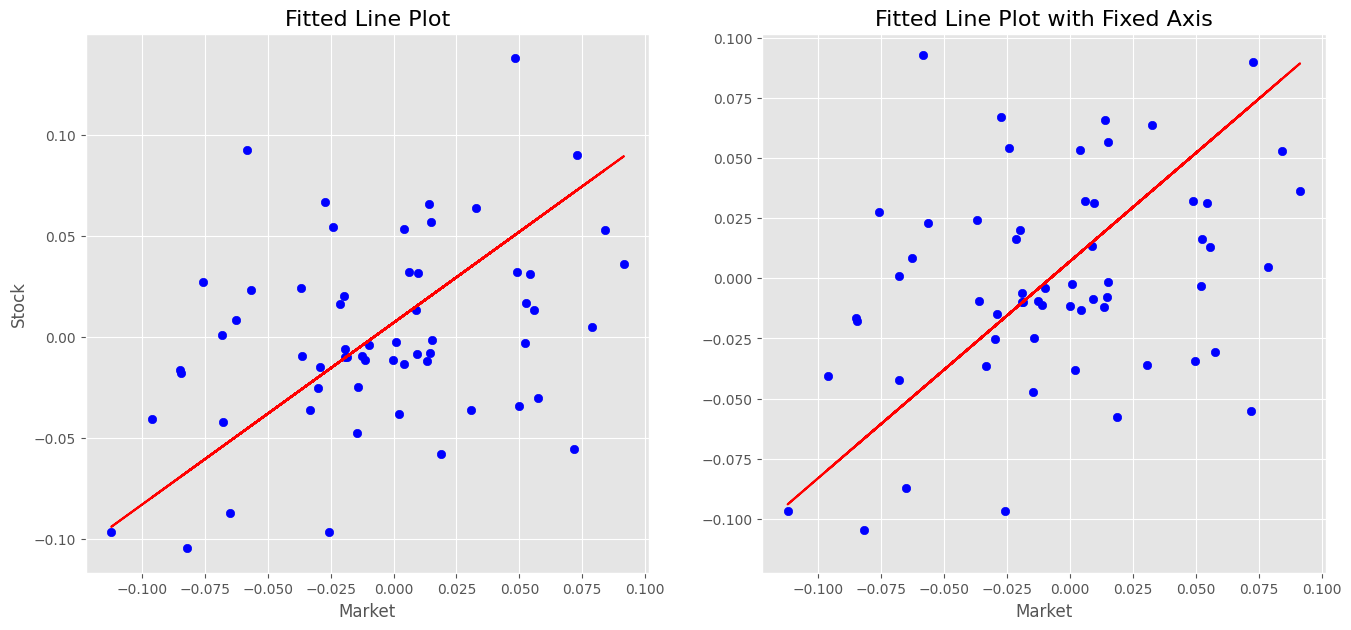

In [70]:
plt.style.use('ggplot')

fig, axes = plt.subplots(nrows = 1, ncols = 2)
fig.set_size_inches(16, 7)

axes[0].scatter(Market_Premium["Market Premium"][:60], Stock_Premium["Stock Premium"][:60], color = 'blue')
axes[0].plot(Market_Premium["Market Premium"][:60],Market_Premium["Market Premium"][:60] * Beta.values + COE['Alpha'].tail(1).values, color = 'red')
axes[0].set(title = "Fitted Line Plot", xlabel = "Market", ylabel = "Stock")
axes[0].title.set_size(16)

axes[1].scatter(Market_Premium["Market Premium"][:60], Stock_Premium["Stock Premium"][:60], color = 'blue')
axes[1].plot(Market_Premium["Market Premium"][:60],Market_Premium["Market Premium"][:60] * Beta.values + COE['Alpha'].tail(1).values, color = 'red')
axes[1].set(title = "Fitted Line Plot with Fixed Axis", xlabel = "Market")
axes[1].title.set_size(16)


# Get default xlim values
default_xlim = axes[0].get_xlim()
default_ylim = axes[0].get_ylim()

# Set ylim using default xlim values and their negative counterparts
axes[1].set_ylim(default_xlim[0], default_xlim[1])
#axes.set_xlim(default_ylim[0], default_ylim[1])

plt.show()

# Trend line

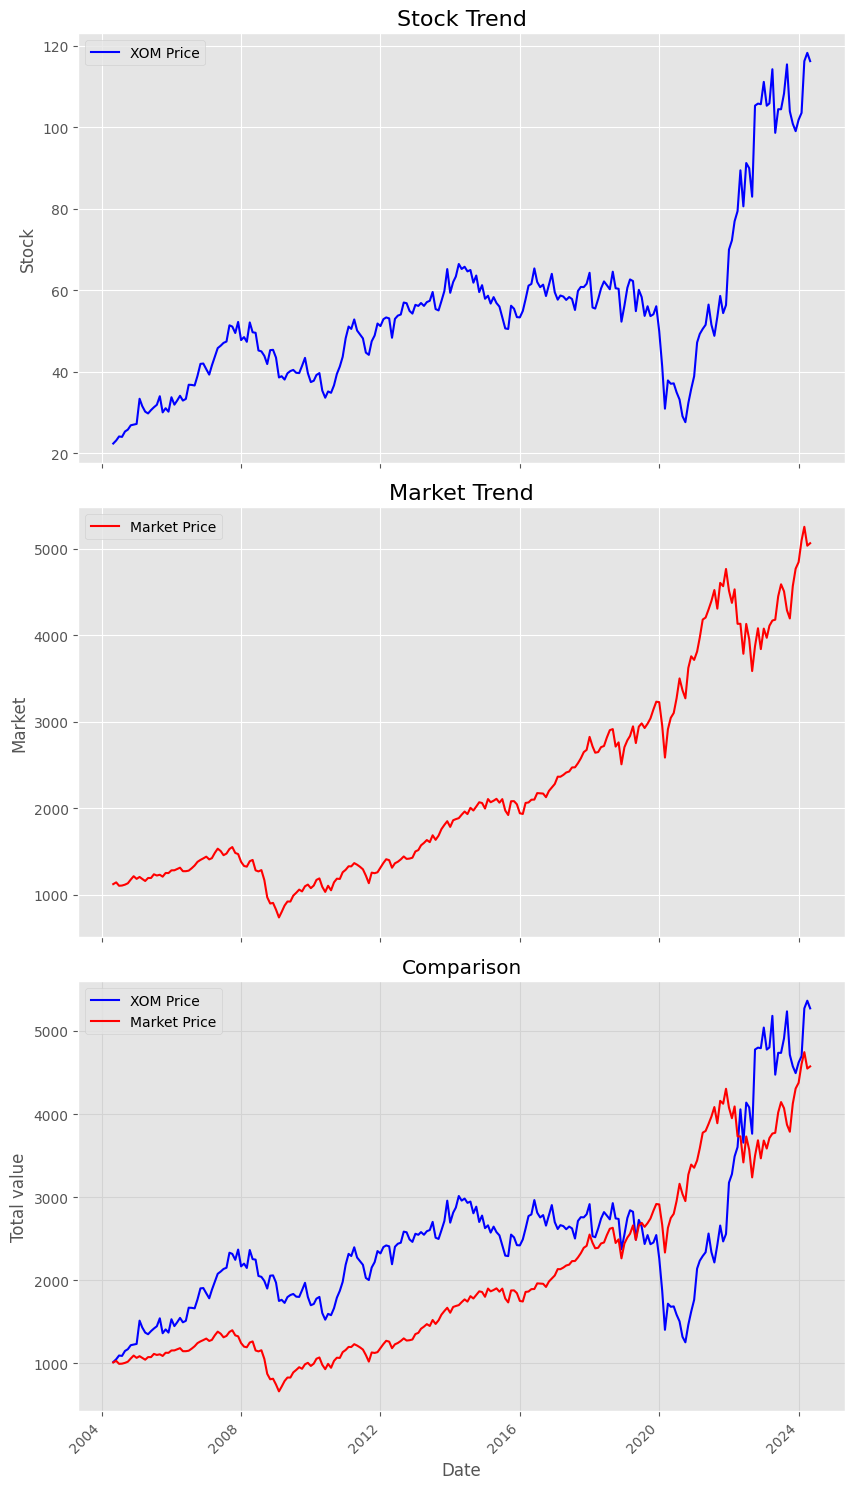

In [71]:
plt.style.use('ggplot')

fig, axes = plt.subplots(nrows = 3, ncols = 1)
fig.set_size_inches(10, 15)
Max_Stock = Stock["Stock Value"].abs().max()*1.05
Max_Market = Market["Market Value"].abs().max()*1.05
max_abs_value = max(Max_Stock.max(), Max_Market.max()) * 1.05
max_abs_value_investment = max((COE["Market Investment"].max()), (COE["Stock Investment"].max())) * 1.05
axes[0].plot(Stock["Date"][B-1:], Stock["Stock Value"][B-1:],color="blue")
axes[0].set(title = "Stock Trend", xlabel = "Date", ylabel = "Stock")
axes[0].title.set_size(16)
plt.grid(color = "lightgray")
axes[1].plot(Market["Date"][B-1:], Market["Market Value"][B-1:],color = "red")
axes[1].set(title = "Market Trend", xlabel = "Date", ylabel = "Market")
axes[2].plot(COE["Date"], COE["Stock Investment"], color = "blue")
axes[2].plot(COE["Date"], COE["Market Investment"], color = "red")


axes[2].set(title = "Comparison", xlabel = "Date", ylabel = "Total value")

fig.autofmt_xdate(rotation=45) #format x-axis as date, rotate 45 degrees
axes[1].title.set_size(16)
"""
axes[0].set_ylim([0,Max_Stock])
axes[1].set_ylim([0,Max_Market])
axes[2].set_ylim([0,max_abs_value_investment])
"""

"""
for i in range(0,3):
  #axes[i].set_facecolor('white') #make background behind grid white
  axes[i].grid(color = "lightgray")
"""

axes[0].legend([Trade_Name +" Price"] ,loc = 2) #move legend to right
axes[1].legend(["Market Price"] ,loc = 2)
axes[2].legend([Trade_Name +" Price", "Market Price",] ,loc = 2)
fig.tight_layout() #use tight layout
fig.subplots_adjust(right = .85) #adjust subplots to make legend fit, adjusted this a bit from smaller figure example!

plt.show()

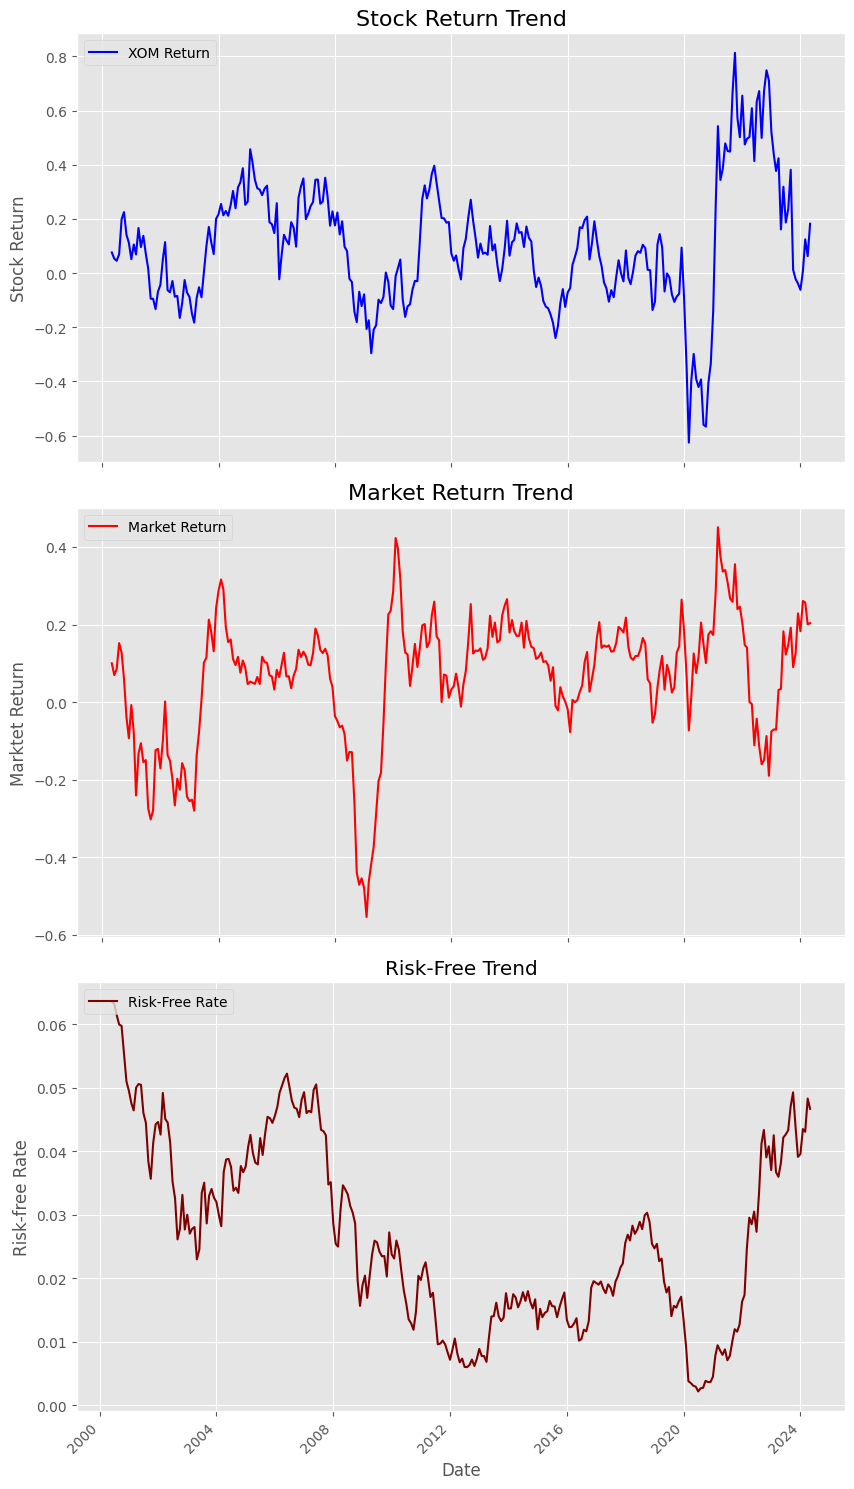

In [72]:
fig, axes = plt.subplots(nrows = 3, ncols = 1)
fig.set_size_inches(10, 15)

#Moving_average_Stock = Stock["Stock Return"].rolling(12).mean()*12
#Moving_average_Market = Market["Market Return"].rolling(12).mean()*12

Moving = 12

axes[0].plot(Stock["Date"], Stock["Stock Return"].rolling(Moving).mean()*12, color = "blue")
axes[0].set(title = "Stock Return Trend", xlabel = "Date", ylabel = "Stock Return")
axes[0].title.set_size(16)
#plt.grid(color = "lightgray")
axes[1].plot(Market["Date"], Market["Market Return"].rolling(Moving).mean()*12, color = "red")
axes[1].set(title = "Market Return Trend", xlabel = "Date", ylabel = "Marktet Return")
axes[2].plot(Risk_Free["Date"][Moving + 1:], (1+Risk_Free["Risk-Free Return"][Moving + 1:])**12-1, color = "maroon")
axes[2].set(title = "Risk-Free Trend", xlabel = "Date", ylabel = "Risk-free Rate")
fig.autofmt_xdate(rotation=45) #format x-axis as date, rotate 45 degrees
axes[1].title.set_size(16)

#max_abs_value = max(Stock["Stock Return"].abs().max(), Market["Market Return"].abs().max()) * 1.05
#axes[0].set_ylim([-max_abs_value, max_abs_value])
#axes[1].set_ylim([-max_abs_value, max_abs_value])
#axes[2].set_ylim([0, Risk_Free["Risk-Free Return"].abs().max()*12*1.05])

"""
for i in range(0,3):
  axes[i].set_facecolor('white') #make background behind grid white
  axes[i].grid(color = "lightgray")
"""

axes[0].legend([Trade_Name +" Return"] ,loc = 2) #move legend to right
axes[1].legend(["Market Return"] ,loc = 2)
axes[2].legend(["Risk-Free Rate"] ,loc = 2)

fig.tight_layout() #use tight layout
fig.subplots_adjust(right = .85) #adjust subplots to make legend fit, adjusted this a bit from smaller figure example!

plt.show()

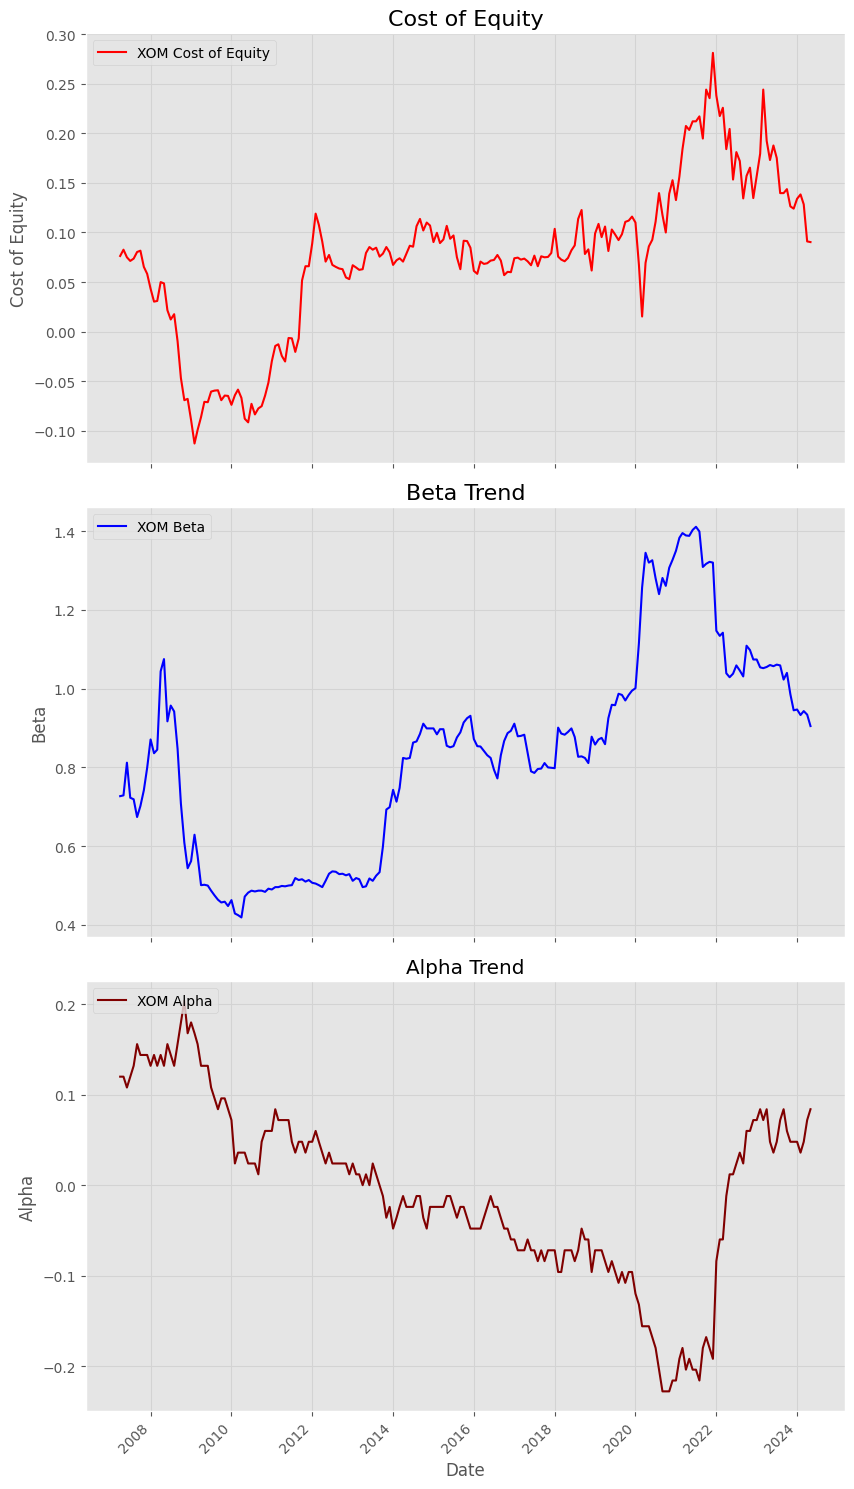

In [73]:
# Chart of cost of equity for each year for stock graphically

fig, axes = plt.subplots(nrows = 3, ncols = 1)
fig.set_size_inches(10, 15)

Moving = 36

axes[0].plot(COE["Date"], COE["Cost of Equity"].rolling(Moving).mean()*12, color = "red")
axes[0].set(title = "Cost of Equity", xlabel = "Date", ylabel = "Cost of Equity")
axes[0].title.set_size(16)
plt.grid(color = "lightgray")
axes[1].plot(COE["Date"][Moving-1:], COE["Beta"][Moving-1:], color = "blue")
axes[1].set(title = "Beta Trend", xlabel = "Date", ylabel = "Beta")
axes[2].plot(COE["Date"][Moving-1:], COE["Alpha"][Moving-1:]*12, color = "maroon")
axes[2].set(title = "Alpha Trend", xlabel = "Date", ylabel = "Alpha")

fig.autofmt_xdate(rotation=45) #format x-axis as date, rotate 45 degrees
axes[1].title.set_size(16)

#axes[0].set_ylim([-COE["Cost of Equity"].abs().max()*1.05*12,COE["Cost of Equity"].abs().max()*1.05*12])
#axes[1].set_ylim([COE["Beta"].min()-0.1,COE["Beta"].max()*1.05])
#axes[2].set_ylim([COE["Alpha"].min()-0.01*12,COE["Alpha"].max()*1.05*12])

for i in range(0,3):
  #axes[i].set_facecolor('white') #make background behind grid white
  axes[i].grid(color = "lightgray")

axes[0].legend([Trade_Name +" Cost of Equity"] ,loc = 2) #move legend to right
axes[1].legend([Trade_Name +" Beta"] ,loc = 2)
axes[2].legend([Trade_Name +" Alpha"] ,loc = 2)

fig.tight_layout() #use tight layout
fig.subplots_adjust(right = .85) #adjust subplots to make legend fit, adjusted this a bit from smaller figure example!

plt.show()